In [129]:
#pip install gym
#pip install gym[classic_control]
#pip install sklearn

In [1]:

import gym
import time
from random import randint
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
from sklearn.preprocessing import KBinsDiscretizer
import time, math, random
from typing import Tuple
  
import workingPlotting 
  
matplotlib.style.use('ggplot')

# Cargo el entorno

In [2]:
env = gym.make('CartPole-v1')

# Simulación random

In [3]:
for _ in range(10):
    obs = env.reset()
    done = False
    while not done:
        policy = randint(0,1)
        obs, reward, done, info = env.step(policy)
        print(obs)
        env.render()
        time.sleep(0.05)
        if done:
            env.reset()
env.close()

[ 0.04853202 -0.21712868 -0.02918927  0.3315842 ]
[ 0.04418944 -0.41182324 -0.02255759  0.6149212 ]
[ 0.03595298 -0.21639349 -0.01025917  0.31521976]
[ 0.03162511 -0.4113678  -0.00395477  0.6046497 ]
[ 0.02339775 -0.6064342   0.00813822  0.89608437]
[ 0.01126907 -0.8016656   0.02605991  1.1913143 ]
[-0.00476424 -0.6068908   0.0498862   0.9069121 ]
[-0.01690206 -0.80265135  0.06802444  1.214848  ]
[-0.03295509 -0.6084697   0.0923214   0.94423306]
[-0.04512448 -0.804706    0.11120606  1.2644378 ]
[-0.0612186  -0.6111671   0.13649482  1.0085499 ]
[-0.07344195 -0.8078209   0.15666582  1.3407921 ]
[-0.08959837 -0.614979    0.18348166  1.1009434 ]
[-0.10189794 -0.8119781   0.20550053  1.4451233 ]
[-0.1181375 -0.6198906  0.234403   1.2230474]
[ 0.04735642  0.22296782 -0.04688255 -0.3361939 ]
[ 0.05181577  0.41872454 -0.05360644 -0.64328474]
[ 0.06019026  0.614551   -0.06647213 -0.95235527]
[ 0.07248128  0.81050146 -0.08551923 -1.2651602 ]
[ 0.08869132  1.0066059  -0.11082244 -1.5833538 ]
[ 0.

Lo primero que tenemos que hacer es convertir el espacio continuo en uno discreto, para eso usamos bins

In [3]:
bins = tuple(np.linspace(-0.000001, 100., 2))
bins

(-1e-06, 100.0)

Las observaciones se componen de cuatro cosas: la posicion del cart, la valocidad, el angulo del pole y la velocidad 'at tip' del pole. Utilizaremos las ultimas 2 para definir los bins.

las acciones posibles son solo 1 o 0, derecha o izquierda respectivamente

In [4]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

### Epsilon Greedy Policy
Crea una política (policy) avara (greedy) de épsilon basada en una función Q dada y épsilon.
       
Devuelve una función que toma el estado como entrada y devuelve las probabilidades para cada acción en forma de matriz de longitud del espacio de acción (conjunto de acciones posibles).

exploration rate:

In [5]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

learning rate: para el valor de alpha

In [6]:
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [7]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

In [8]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore < exploration_rate(e) : 
        action = env.action_space.sample()
        print('explore')
    else:
        action = optimal_policy(state,Q)
        print('exploit')
    return action

Funcion que devuelve la funcion de policy:

In [9]:
def EGreedyPolicy(Q, epsilon, num_actions):
    def policyFunction(state):
   
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        
        state_tup = state[0],state[1],state[2],state[3]

        best_action = np.argmax(Q[state_tup])
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities
   
    return policyFunction

### Q learning
Control de TD (temporal difference) fuera de política. Encuentra la política óptima (greedy) mientras mejora siguiendo una política épsilon greedy

El factor de descuento, alpha y epsilon tienen un default value en Q-Learning

- Función de valor de acción
- Un diccionario anidado que mapea estado -> (acción -> valor-acción)

Luego se mantiene un trackeo de estadisticas utiles como largo y recompensa de los episodios

Se crea la policy epsilon greedy apropiada para el espacio de accion

Luego para cada uno de los episodios:
- se resetea el estado a el reset del ambiente y elige la primera accion
- se loopea la iteracion de obetener la probabilidad de todas las acciones del estado actual
- se elige la accion segun la ditribucion de probabilidad
- se toma la accion y se obtiene la recompensa
- transiciona al siguiente estado
- se actualizan las estadisticas antes mencionadas: largo de episodio y recompensa

- si termina el episodio se acaba (se usa el done de step para confirmar esto)


Diferencia temporal para actualizar el valor de Q en un par de estado-accion

In [10]:
Q = np.zeros(n_bins + (env.action_space.n,))

In [11]:
def new_Q_value(reward : float ,  new_state : tuple , discount_factor=1 ) -> float:

    future_optimal_value = np.max(Q[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

### Entrenamiento

- Discretizar el estado en bins
- explotar la accion de la policy
- explorar accion random
- incrementar el ambiente
- actualizar Q

In [12]:
episodes = 5000

stats = workingPlotting.EpisodeStats(
		episode_lengths = np.zeros(episodes),
		episode_rewards = np.zeros(episodes))	

for e in range(episodes):
    
    current_state, done = discretizer(*env.reset()), False
    
    for t in itertools.count():
        
        action = epsilon_greedy_policy(current_state, Q) 
        
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        stats.episode_rewards[e] += reward
        stats.episode_lengths[e] = t

        alpha = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q[current_state][action]
        Q[current_state][action] = (1-alpha)*old_value + alpha*learnt_value

        if done:
            break
        
        current_state = new_state
        
        #env.render()


explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
exploit
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
exploit
explore
explore
explore
explore
explore
explore
explore
exploit
explore
explore
exploit
explore
exploit
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
exploit
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
exploit
exploit
explore
explore
explore
explore
exploit
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
exploit
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore
explore


Comentamos el render para que ejecute mas rapido

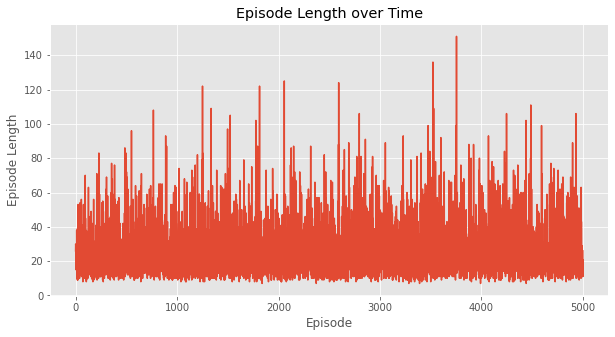

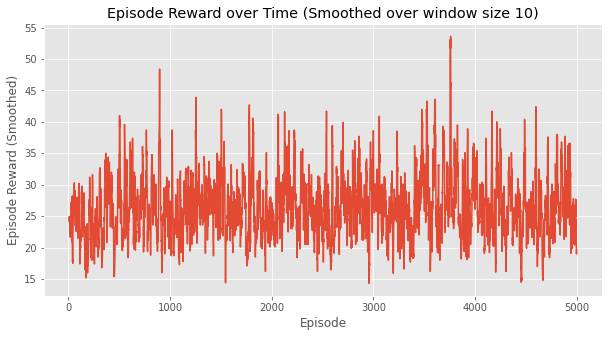

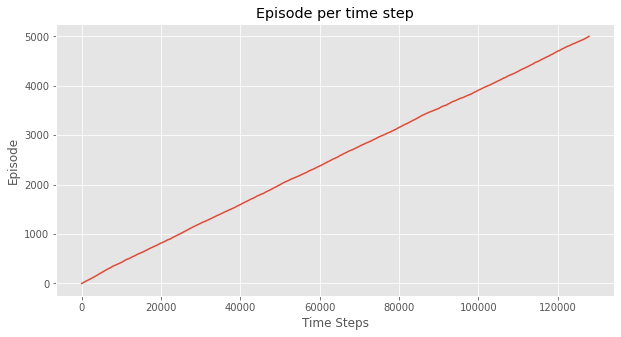

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
workingPlotting.plot_episode_stats(stats)

# Simulacion con nueva policy

In [14]:
for _ in range(10):
    obs = env.reset()
    current_state, done = discretizer(*env.reset()), False

    while not done:
        policy = epsilon_greedy_policy(current_state, Q)
        obs, reward, done, info = env.step(policy)
        print(obs)
        env.render()
        time.sleep(0.05)
        if done:
            env.reset()
env.close()

explore
[-0.02480223 -0.23223762  0.00845486  0.2670554 ]
explore
[-0.02944698 -0.03723735  0.01379597 -0.02294887]
explore
[-0.03019173 -0.2325544   0.01333699  0.2740547 ]
explore
[-0.03484282 -0.03762526  0.01881808 -0.01439204]
explore
[-0.03559532 -0.23301196  0.01853024  0.2841683 ]
explore
[-0.04025556 -0.42839324  0.02421361  0.5826375 ]
explore
[-0.04882342 -0.23361874  0.03586636  0.2976795 ]
explore
[-0.0534958  -0.03902593  0.04181995  0.01652046]
explore
[-0.05427632  0.1554721   0.04215036 -0.26268002]
explore
[-0.05116687  0.34996784  0.03689676 -0.54177594]
explore
[-0.04416752  0.15434726  0.02606124 -0.23769961]
explore
[-0.04108057  0.3490874   0.02130725 -0.5220495 ]
explore
[-0.03409883  0.54390305  0.01086626 -0.80794275]
explore
[-0.02322076  0.7388744  -0.0052926  -1.0971879 ]
explore
[-0.00844328  0.93406564 -0.02723636 -1.3915267 ]
explore
[ 0.01023804  0.7392932  -0.05506689 -1.1074829 ]
explore
[ 0.0250239   0.54493666 -0.07721655 -0.83257145]
explore
[ 0.03